# Hands-On: Time Series Analysis (Physics) — 1.5h

**Topics:** Autocorrelation, ARIMA, Fourier, Wavelets  
**Dataset:** Monthly Sunspot Numbers (astronomy/solar physics; bundled with `statsmodels`).  
**Goal:** Apply core time-series tools to a real physics time series and interpret results like a physicist (oscillations, periodicities, prediction).

> **Time plan (suggested, 90 min total):**  
> • 0–10 min: Setup & data exploration  
> • 10–30 min: Autocorrelation (ACF/PACF), stationarity check  
> • 30–55 min: ARIMA modeling (fit → diagnostics → forecast)  
> • 55–75 min: Fourier analysis (FFT, power spectrum, dominant periods)  
> • 75–90 min: Wavelet analysis (time-localized periodicities)

## Learning outcomes
By the end, you should be able to:
- Load a physics time series and get it into a tidy format.
- Inspect autocorrelation structures and reason about stationarity.
- Fit and diagnose an **ARIMA** model for short-term forecasting.
- Use **FFT** to estimate dominant periodicities (power spectrum).
- Use **wavelets** to reveal **time-varying** periodic content.

## Environment & Setup
This notebook assumes:
- Python ≥ 3.9
- `numpy`, `pandas`, `matplotlib`, `scipy`, `statsmodels`, `pywt` (PyWavelets)

> If `pywt` is not available, the code will fall back to a Morlet-based CWT via `scipy.signal.cwt`.

In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Wavelets: try PyWavelets, fall back to SciPy cwt
try:
    import pywt
    HAVE_PYWT = True
except Exception:
    HAVE_PYWT = False

# Plot settings (keep simple)
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True

print("HAVE_PYWT:", HAVE_PYWT)

HAVE_PYWT: True


## 1) Load Physics Data: Monthly Sunspot Numbers
**Why sunspots?** They are a classic physics/astronomy time series with known ~11-year cycles.  
We use the dataset bundled with `statsmodels` → *no internet required*.

In [2]:

# Load monthly sunspot data (built-in, 1700–2008)
sun = sm.datasets.sunspots.load_pandas().data
sun.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [3]:

# Make a proper datetime index and tidy series
sun['YEAR'] = sun['YEAR'].astype(int)
# The dataset has 'SUNACTIVITY' per **year**, but there's also a monthly version in statsmodels.
# We'll instead use the **monthly** sunspots dataset: 'sm.tsa.datasets.sunspots' (deprecated in some versions).
# Robust path: use the classic yearly first, then try to fetch monthly if available.

try:
    # Some statsmodels versions expose monthly sunspots here:
    from statsmodels.datasets import sunspots as sm_sun_monthly
    sun_m = sm_sun_monthly.load_pandas().data.copy()
    # Columns often include 'YEAR' and 'SUNACTIVITY'; monthly sometimes includes 'MONTH'
    if 'MONTH' in sun_m.columns:
        sun_m['MONTH'] = sun_m['MONTH'].astype(int)
        sun_m['DATE'] = pd.to_datetime(dict(year=sun_m['YEAR'].astype(int),
                                           month=sun_m['MONTH'].astype(int),
                                           day=1))
        ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
    else:
        # Fallback: construct a monthly index from year fractions if present
        if 'PERIOD' in sun_m.columns:
            # PERIOD might be fractional year; convert to datetime approx by month
            years = sun_m['YEAR'].astype(int)
            months = ((sun_m['PERIOD'] - np.floor(sun_m['PERIOD'])) * 12 + 1).round().astype(int).clip(1,12)
            sun_m['DATE'] = pd.to_datetime(dict(year=years, month=months, day=1))
            ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
        else:
            # As last resort, stick to yearly
            ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))
except Exception:
    # Fall back to yearly data only
    ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))

ts = ts.asfreq('MS') if ts.index.inferred_type in ('datetime64', 'datetime') else ts
ts = ts.dropna()
ts.name = 'sunspots'
ts.head()

,sunspots
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


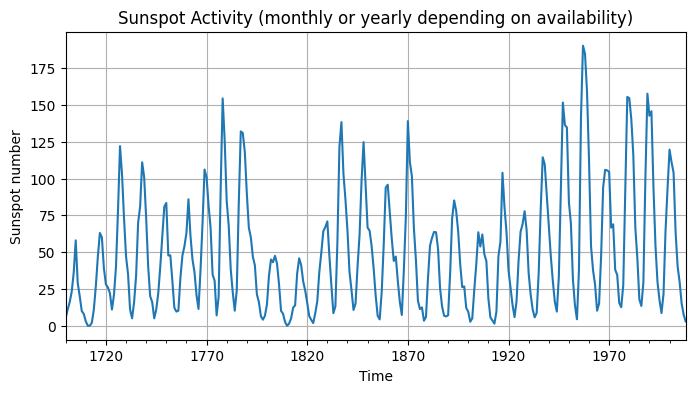

In [4]:

# Quick visualization
ax = ts.plot(title='Sunspot Activity (monthly or yearly depending on availability)')
ax.set_xlabel('Time')
ax.set_ylabel('Sunspot number')
plt.show()

### Task 1.1 — Basic Exploration
1. Compute summary stats: mean, std, min, max.  
2. Plot a rolling mean and rolling std (window=24 months if monthly, or window=5 if yearly).  
3. Comment: do you see long-term cycles?

count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: sunspots, dtype: float64


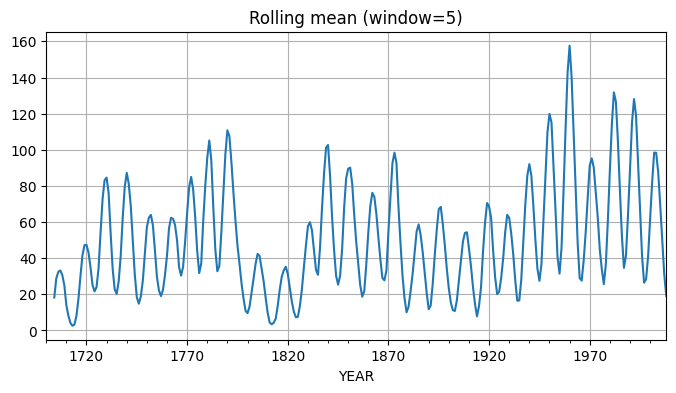

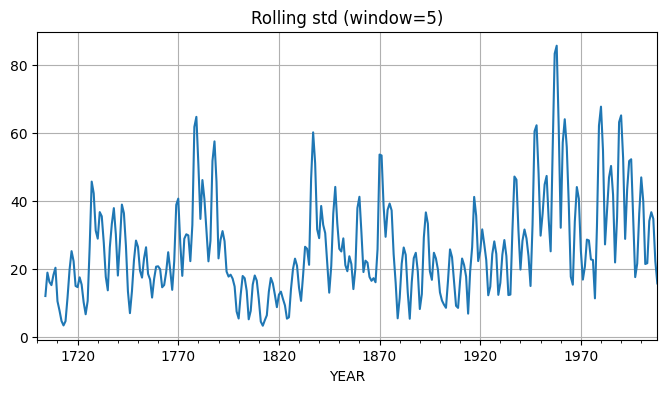

In [5]:

# TODO: Your code here
roll_window = 24 if (ts.index.freqstr == 'MS') else 5
desc = ts.describe()
print(desc)

ts.rolling(roll_window).mean().plot()
plt.title(f'Rolling mean (window={roll_window})')
plt.show()

ts.rolling(roll_window).std().plot()
plt.title(f'Rolling std (window={roll_window})')
plt.show()

## 2) Autocorrelation & Stationarity
We examine the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)**.  
We also run an **ADF test** (Augmented Dickey–Fuller) to gauge stationarity.

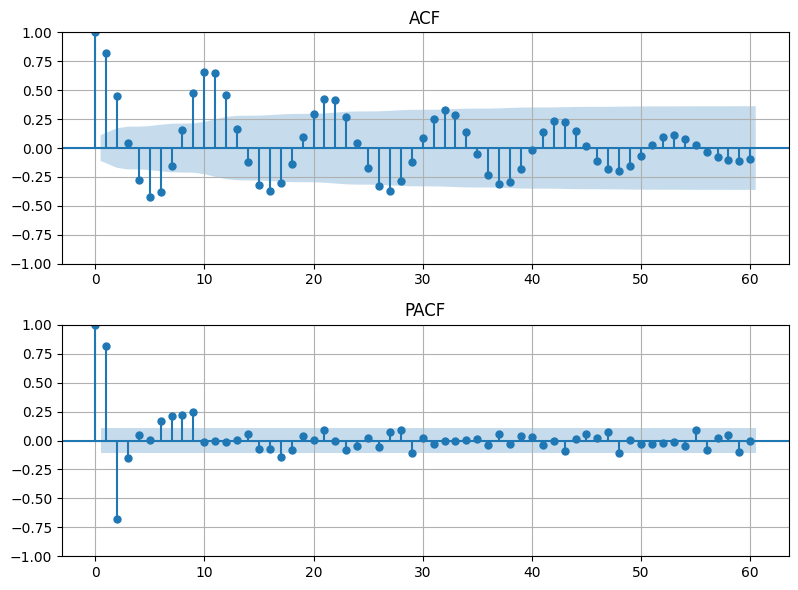

ADF statistic: -2.8377807249381943
p-value: 0.053076421728120673
Critical value (1%): -3.4523371197407404
Critical value (5%): -2.871222860740741
Critical value (10%): -2.571929211111111


In [6]:

# ACF & PACF plots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(ts.dropna(), ax=axes[0], lags=60)
axes[0].set_title('ACF')
plot_pacf(ts.dropna(), ax=axes[1], lags=60, method='ywm')
axes[1].set_title('PACF')
plt.tight_layout()
plt.show()

# ADF test
adf_res = adfuller(ts.dropna())
print("ADF statistic:", adf_res[0])
print("p-value:", adf_res[1])
for k, v in adf_res[4].items():
    print(f'Critical value ({k}): {v}')

### Task 2.1 — Differencing (if needed)
If the series looks non-stationary, difference it (e.g., `ts.diff().dropna()` or seasonal diff `ts.diff(12)`) and repeat ACF/PACF & ADF.  
**Question:** What differencing makes it *most* stationary without over-differencing?

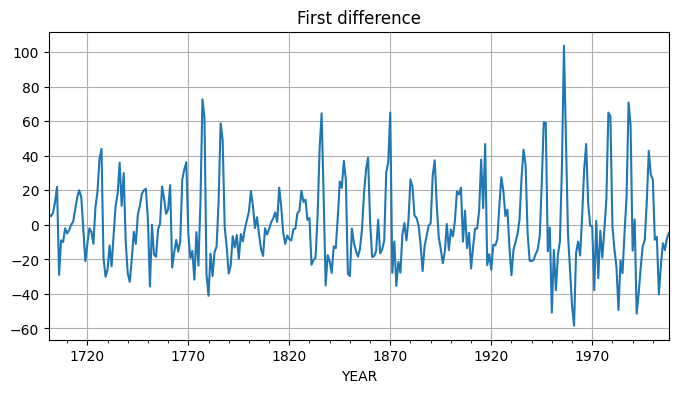

In [7]:

# TODO: Try first differences and seasonal differences (if monthly)
d1 = ts.diff().dropna()
ax = d1.plot(title='First difference')
plt.show()

if ts.index.freqstr == 'MS':
    d12 = ts.diff(12).dropna()
    ax = d12.plot(title='Seasonal difference (lag 12)')
    plt.show()

## 3) ARIMA Modeling
We choose an ARIMA (or seasonal ARIMA) based on ACF/PACF cues and iterate quickly.  
**Tip:** Start simple (ARIMA(p, d, q)), then try seasonal (SARIMA) if strong seasonality is present (monthly → possibly `m=12`).

In [8]:

# Simple search over small ARIMA orders (keep tiny to fit in class time)
from itertools import product
import warnings
warnings.filterwarnings("ignore")

y = ts.dropna()

candidates = [(p,1,q) for p,q in product(range(0,3), repeat=2)]
best = (None, np.inf, None)

for order in candidates:
    try:
        model = ARIMA(y, order=order).fit()
        aic = model.aic
        if aic < best[1]:
            best = (order, aic, model)
    except Exception:
        pass

print("Best ARIMA order (non-seasonal):", best[0], "AIC:", best[1])
best_model = best[2]
if best_model is not None:
    print(best_model.summary())

Best ARIMA order (non-seasonal): (2, 1, 2) AIC: 2576.3259015377143
                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                  309
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1283.163
Date:                Sat, 27 Sep 2025   AIC                           2576.326
Time:                        17:37:05   BIC                           2594.976
Sample:                    01-01-1700   HQIC                          2583.783
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6098      0.026     61.536      0.000       1.559       1.661
ar.L2         -0.9381      0.023    -41.582      0.000      -0.9

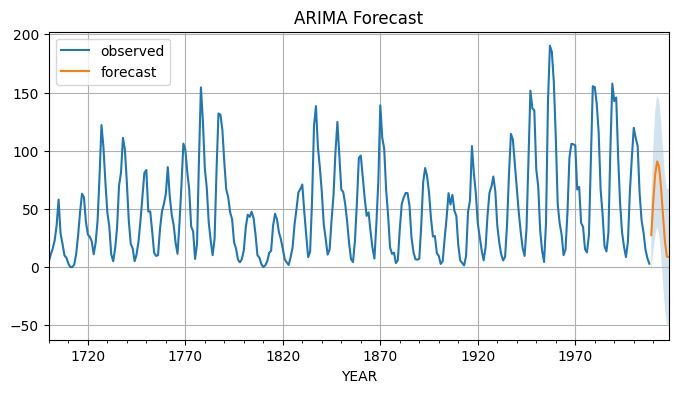

In [9]:

# Forecast next horizon (e.g., next 60 months or next 10 years if yearly)
steps = 60 if (ts.index.freqstr == 'MS') else 10
if best_model is not None:
    fc = best_model.get_forecast(steps=steps)
    fc_mean = fc.predicted_mean
    fc_ci = fc.conf_int()

    ax = y.plot(label='observed')
    fc_mean.plot(ax=ax, label='forecast')
    ax.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2)
    ax.set_title('ARIMA Forecast')
    ax.legend()
    plt.show()
else:
    print("No ARIMA model was fit.")

### Task 3.1 — Seasonal ARIMA (Optional if time)
If `MS` (monthly) data is available: try a small seasonal model, e.g. `SARIMA(p, d, q) x (P, D, Q, 12)`.

In [10]:

# OPTIONAL: quick seasonal ARIMA if monthly
if ts.index.freqstr == 'MS':
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    y = ts.dropna()

    try:
        model_s = SARIMAX(y, order=(1,1,1), seasonal_order=(1,0,1,12)).fit(disp=False)
        print(model_s.summary())
        steps = 60
        fc_s = model_s.get_forecast(steps=steps)
        fc_mean_s = fc_s.predicted_mean
        fc_ci_s = fc_s.conf_int()

        ax = y.plot(label='observed')
        fc_mean_s.plot(ax=ax, label='SARIMA Forecast')
        ax.fill_between(fc_ci_s.index, fc_ci_s.iloc[:,0], fc_ci_s.iloc[:,1], alpha=0.2)
        ax.set_title('Seasonal ARIMA Forecast (m=12)')
        ax.legend()
        plt.show()
    except Exception as e:
        print("Seasonal model failed:", e)

## 4) Fourier Analysis (FFT)
Compute the **power spectrum** via FFT to identify dominant periodicities (e.g., the ~11-year sunspot cycle).  
We convert to zero-mean, apply a window, compute FFT magnitude, and plot vs. frequency.

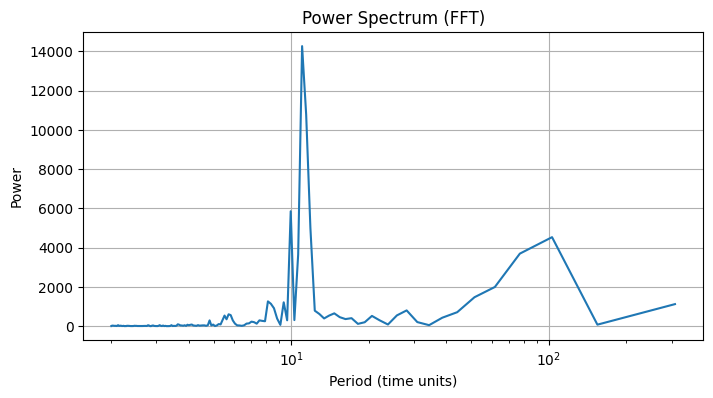

Dominant period ~ 11.04 time units (months if monthly; years if yearly)


In [11]:

# Build evenly-sampled series (already regular). Remove NaNs, detrend (mean)
x = y.values.astype(float)
x = x - np.nanmean(x)

# Apply a Hanning window to reduce spectral leakage
win = np.hanning(len(x))
xw = x * win

# FFT
X = np.fft.rfft(xw)
freqs = np.fft.rfftfreq(len(xw), d=1.0)  # sampling interval = 1 time unit (month or year)
power = (np.abs(X)**2) / len(xw)

# Convert frequency to period in time units (months or years)
with np.errstate(divide='ignore'):
    period = np.where(freqs>0, 1.0/freqs, np.inf)

fig, ax = plt.subplots()
ax.plot(period[1:], power[1:])  # skip the zero-frequency (mean)
ax.set_xlabel('Period (time units)')
ax.set_ylabel('Power')
ax.set_title('Power Spectrum (FFT)')
ax.set_xscale('log')
plt.show()

# Print dominant period estimate
idx = np.argmax(power[1:]) + 1
dom_period = period[idx]
print(f"Dominant period ~ {dom_period:.2f} time units (months if monthly; years if yearly)")

### Task 4.1 — Windowing & Detrending
Try different windows (`np.hanning`, `np.hamming`) and detrending (remove linear trend using `signal.detrend`).  
**Question:** How sensitive is the dominant period to preprocessing?

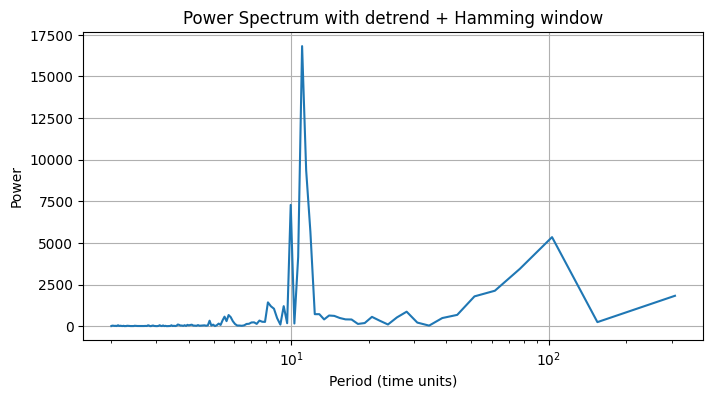

In [12]:

# TODO: Experiment with Hamming window & linear detrend
x_dt = signal.detrend(x, type='linear')
win2 = np.hamming(len(x_dt))
X2 = np.fft.rfft(x_dt * win2)
power2 = (np.abs(X2)**2) / len(x_dt)

plt.plot(period[1:], power2[1:])
plt.xlabel('Period (time units)')
plt.ylabel('Power')
plt.title('Power Spectrum with detrend + Hamming window')
plt.xscale('log')
plt.show()

## 5) Wavelet Analysis
Wavelets show **how** dominant periods evolve over time.  
We use the **Morlet** wavelet via PyWavelets (`cwt`) if available; otherwise use SciPy's `signal.cwt`.

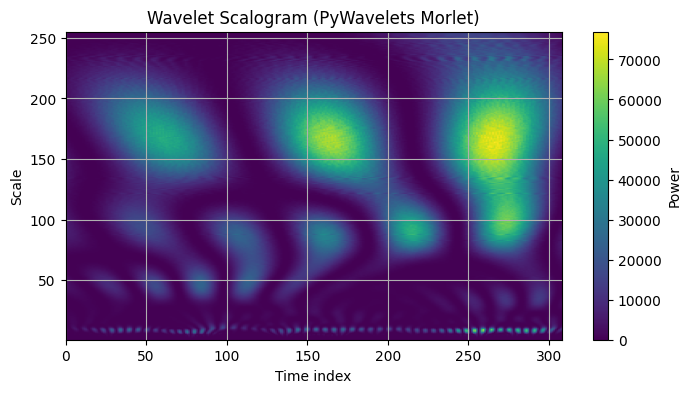

In [13]:

series = y.dropna().astype(float).values
t = np.arange(len(series))

if HAVE_PYWT:
    # PyWavelets CWT with Morlet
    scales = np.arange(1, 256)
    coefficients, freqs_w = pywt.cwt(series, scales=scales, wavelet='morl')
    power_w = (np.abs(coefficients))**2

    plt.imshow(power_w, aspect='auto', origin='lower',
               extent=[t[0], t[-1], scales[0], scales[-1]])
    plt.xlabel('Time index')
    plt.ylabel('Scale')
    plt.title('Wavelet Scalogram (PyWavelets Morlet)')
    plt.colorbar(label='Power')
    plt.show()
else:
    # SciPy fallback with Morlet (width parameter tunes time/freq tradeoff)
    widths = np.arange(1, 256)
    cwtmatr = signal.cwt(series, signal.morlet2, widths, w=6.0)
    power_w = (np.abs(cwtmatr))**2

    plt.imshow(power_w, aspect='auto', origin='lower',
               extent=[t[0], t[-1], widths[0], widths[-1]])
    plt.xlabel('Time index')
    plt.ylabel('Width (scale)')
    plt.title('Wavelet Scalogram (SciPy Morlet2)')
    plt.colorbar(label='Power')
    plt.show()

### Task 5.1 — Interpret time-localized periodicities
- Identify bands/scales of strong power.
- Do you see changes in periodicity strength over time? How does this compare to the FFT results?

## 6) Wrap-up (Short Reflection)
- What does ACF/PACF tell you about memory and seasonality?
- Compare ARIMA forecasts with physical expectations (e.g., cycle phases).
- How do FFT vs. Wavelets complement each other?
- If you had **no stationarity**, which tool(s) would you trust more and why?